# Markov Chain Monte Carlo

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline

In [3]:
sns.set()

## Good King Markov and his Island Kingdom

### 8.1

In [4]:
num_weeks = int(1e5)
positions = np.zeros(num_weeks)
current = 10
for i in range(num_weeks):
    # record current position
    positions[i] = current

    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])
    # now make sure he loops around the archipelago
    if proposal < 1:
        proposal = 10
    elif proposal > 10:
        proposal = 1
        
    # move?
    prob_move = proposal/current
    current = proposal if np.random.uniform() < prob_move else current

## Markov Chain Monte Carlo

## Easy HMC:map2stan

### 8.2

In [5]:
d = pd.read_csv("data/rugged.csv", delimiter=";")
d["log_gdp"] = np.log(d["rgdppc_2000"])
dd = d.dropna(subset=["rgdppc_2000"])

### 8.3

In [6]:
with pm.Model() as m8_1:
    sigma = pm.Uniform("sigma", 0, 10)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*dd["rugged"] +\
                                bA*dd["cont_africa"] +\
                                bAR*dd["rugged"]*dd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace8_1 = pm.sample(draws=1000, tune=1000)
    
(pm.summary(trace8_1, varnames=["a", "bR", "bA", "bAR", "sigma"], alpha=0.11)
 .round(2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 445.63draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.21,0.14,0.00,8.98,9.43,868.99,1.00
bR,-0.20,0.08,0.00,-0.31,-0.07,875.04,1.00
bA,-1.93,0.23,0.01,-2.29,-1.55,756.44,1.00
bAR,0.38,0.13,0.00,0.19,0.60,693.12,1.01
sigma,0.95,0.05,0.00,0.87,1.04,1831.06,1.00


### 8.4

In [7]:
dd_trim = dd[["log_gdp", "rugged", "cont_africa"]]
dd_trim.head()

,log_gdp,rugged,cont_africa
2,7.492609,0.858,1
4,8.216929,3.427,0
7,9.933263,0.769,0
8,9.407032,0.775,0
9,7.792343,2.688,0


### 8.5

Since I've been using MCMC all along, nothing changes, I will stick to the same model names even if it's not STAN under the hood.

In [8]:
with pm.Model() as m8_1stan:
    sigma = pm.HalfCauchy("sigma", 2)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*dd_trim["rugged"] +\
                                bA*dd_trim["cont_africa"] +\
                                bAR*dd_trim["rugged"]*dd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd_trim["log_gdp"])
    trace8_1stan = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 732.52draws/s] 


### 8.6

In [9]:
(pm.summary(trace8_1stan, varnames=["a", "bR", "bA", "bAR", "sigma"], alpha=0.11)
 .round(2))

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.22,0.14,0.01,9.00,9.44,735.62,1.0
bR,-0.20,0.08,0.00,-0.33,-0.08,846.39,1.0
bA,-1.95,0.23,0.01,-2.35,-1.60,955.56,1.0
bAR,0.39,0.13,0.00,0.17,0.59,1059.03,1.0
sigma,0.95,0.06,0.00,0.86,1.04,1911.99,1.0


### 8.7

In [10]:
m8_1stan_4chains = pm.sample(1000, chains=4, cores=4, model=m8_1stan)
(pm.summary(m8_1stan_4chains, varnames=["a", "bR", "bA", "bAR", "sigma"], alpha=0.11)
 .round(2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:08<00:00, 737.47draws/s] 
The acceptance probability does not match the target. It is 0.8914096323920458, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.22,0.14,0.00,9.00,9.44,1554.50,1.0
bR,-0.20,0.08,0.00,-0.33,-0.08,1669.14,1.0
bA,-1.94,0.23,0.01,-2.31,-1.57,1580.35,1.0
bAR,0.39,0.13,0.00,0.17,0.60,1742.22,1.0
sigma,0.95,0.05,0.00,0.87,1.03,2517.40,1.0


### 8.8

In [11]:
post = pm.trace_to_dataframe(trace8_1stan, varnames=["a", "bR", "bA", "bAR", "sigma"])
post.head()

,a,bR,bA,bAR,sigma
0,9.111626,-0.171291,-1.853371,0.180801,0.918655
1,9.182767,-0.139801,-1.374679,0.206873,0.883743
2,9.133785,-0.116016,-2.291528,0.404233,1.030381
3,8.991686,-0.033369,-1.630665,0.297250,0.991647
4,9.144463,-0.142846,-1.801663,0.336347,0.896420


### 8.9 - 8.10

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


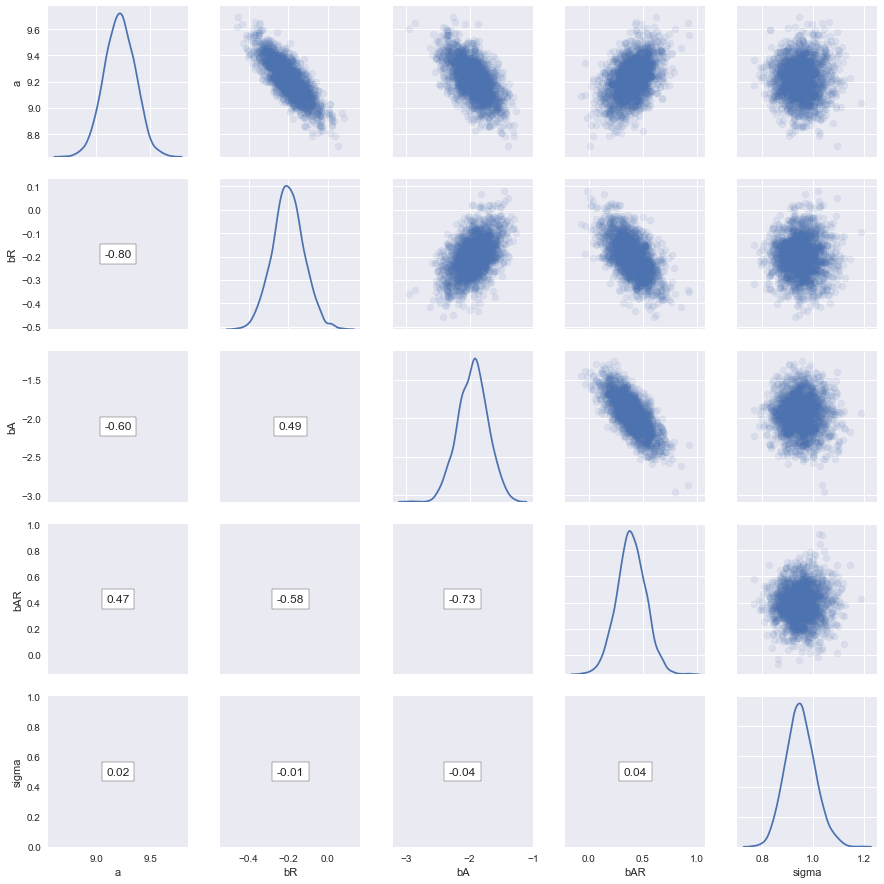

In [12]:
def plot_corr(x, y, **kwargs):
    corrcoeff = np.corrcoef(x, y)[0, 1]
    artist = AnchoredText('{:.2f}'.format(corrcoeff), loc=10)
    plt.gca().add_artist(artist)
    plt.grid(b=False)

grid = (sns.PairGrid(data=post,
                     diag_sharey=False)
        .map_diag(sns.kdeplot)
        .map_upper(plt.scatter, alpha=0.1)
        .map_lower(plot_corr))

### 8.11

In [13]:
m8_1stan

In [14]:
pm.waic(trace8_1stan, m8_1stan)

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=469.515803897099, WAIC_se=14.827079376926958, p_WAIC=5.167956998036101, var_warn=1)

### 8.12

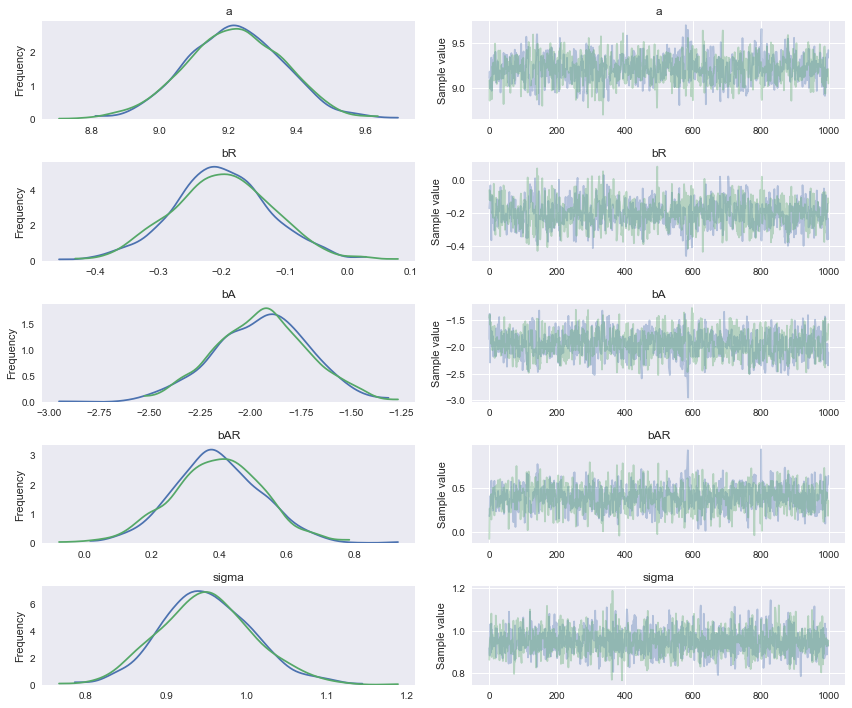

In [15]:
pm.traceplot(trace8_1stan, varnames=["a", "bR", "bA", "bAR", "sigma"]);